In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from math import sqrt
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn import metrics
from sklearn import datasets
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
# Implementation of the Keras API meant to be a high-level API for TensorFlow
from tensorflow import keras
 # TensorFlow backend (Code for model cloning, plus model-related API entries)
from keras.models import Sequential # Model module
from keras.layers import Flatten, Dense, Dropout, Activation # Core layers
from keras.layers import Convolution2D, MaxPooling2D # CNN layers
from keras.utils import np_utils # Utilities

import patsy
from itertools import combinations

from imblearn.over_sampling import SMOTE

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
import re
import twitter

%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Build and document a working model, prototype, recommendation, or solution

Note: The new Statcast metrics are available beginning from the 2015 baseball season to the current season. I downloaded the 2015-2017 baseball season data for all teams which will be used in the data modeling.

## [pybaseball](https://github.com/jldbc/pybaseball) 
Pull current and historical baseball statistics using Python (Statcast, Baseball Reference, FanGraphs)

`pybaseball` is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the [docs](https://github.com/jldbc/pybaseball/tree/master/docs) for a comprehensive list of data acquisition functions.

**Statcast**

The statcast function retrieves pitch-level statcast data for a given date or range or dates.

statcast(start_dt=[yesterday's date], end_dt=None, team=None)

In [2]:
# Pull advanced metrics from Major League Baseball's Statcast system
#from pybaseball import statcast

# Look up a player's MLBAM, Retrosheet, FanGraphs, and Baseball Reference ID by name
#from pybaseball import playerid_lookup

### Reading a File

In [3]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/GeneralAssembly/Projects/Datasets/'

In [4]:
# Read file into DataFrame
# Note: header=0 disables the header from the file
all_MLB_teams2015_2017 = pd.read_csv(data_path + 'all_MLB_teams2015_2017.csv', header=0) # Comma-separated values file

### Examine the DataFrame

In [5]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017.shape[0], all_MLB_teams2015_2017.shape[1]))

Rows: 2139920, Cols: 91


In [6]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_MLB_teams2015_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139920 entries, 0 to 2139919
Data columns (total 91 columns):
Unnamed: 0                         int64
index                              int64
pitch_type                         object
game_date                          object
release_speed                      float64
release_pos_x                      float64
release_pos_z                      float64
player_name                        object
batter                             float64
pitcher                            float64
events                             object
description                        object
spin_dir                           float64
spin_rate_deprecated               float64
break_angle_deprecated             float64
break_length_deprecated            float64
zone                               float64
des                                object
game_type                          object
stand                              object
p_throws                           obje

In [7]:
# Column names (which is "an index")
#all_MLB_teams2015_2017.columns

In [8]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)

In [9]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_MLB_teams2015_2017.head().append(all_MLB_teams2015_2017.tail())

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2139919,702491,17584,FF,2015-04-05,93.6,2.5520,5.5293,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139918,702490,17583,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139917,702489,17582,FF,2015-04-05,94.8,2.6266,5.2936,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139916,702488,17581,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139915,702487,17580,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,4,650,FT,2017-10-01,95.9,-0.8903,6.1341,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
3,3,636,CH,2017-10-01,82.8,-0.9901,6.0626,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
2,2,620,FF,2017-10-01,94.7,-0.6208,6.3387,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
1,1,615,FC,2017-10-01,91.8,-1.0777,6.1772,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
0,0,597,FC,2017-10-01,91.9,-1.1948,5.9921,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN


#### Identifying important columns to include in the DataFrame.

In [10]:
# Select multiple columns
# Note: release_speed = Pitch Velocity (MPH)
#       bb_type = Batted Ball Type
#       launch_speed = Exit Velocity (MPH)
#       launch_angle = Launch Angle (Degrees)
baseball_cols = ['game_date', 'home_team', 'away_team', 'player_name', 'pitcher', 'pitch_type', 'pitch_name', 'release_speed',
                 'batter', 'events', 'description', 'bb_type', 'des', 'launch_speed', 'launch_angle', 'hit_distance_sc'] 
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017[baseball_cols]

In [11]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 2139920, Cols: 16


In [12]:
# Print the first 5 rows of the DataFrame
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,release_speed,batter,events,description,bb_type,des,launch_speed,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.4,572761.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.8,572761.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.6,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,75.9,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN


In [13]:
# Rename one or more columns in the original DataFrame rather than returning a new view
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.rename(columns={'release_speed': 'pitch_velocity',
                                                                        'bb_type': 'batted_ball_type',
                                                                        'launch_speed': 'exit_velocity'})

In [14]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_MLB_teams2015_2017_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139920 entries, 2139919 to 0
Data columns (total 16 columns):
game_date           object
home_team           object
away_team           object
player_name         object
pitcher             float64
pitch_type          object
pitch_name          object
pitch_velocity      float64
batter              float64
events              object
description         object
batted_ball_type    object
des                 object
exit_velocity       float64
launch_angle        float64
hit_distance_sc     float64
dtypes: float64(6), object(10)
memory usage: 277.5+ MB


### Handling Missing Values

In [15]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date                 0
home_team                 0
away_team                 0
player_name               0
pitcher                   0
pitch_type             3814
pitch_name             3814
pitch_velocity         2505
batter                    0
events              1586052
description               0
batted_ball_type    1752979
des                 1586054
exit_velocity       1585044
launch_angle        1585019
hit_distance_sc     1631442
dtype: int64

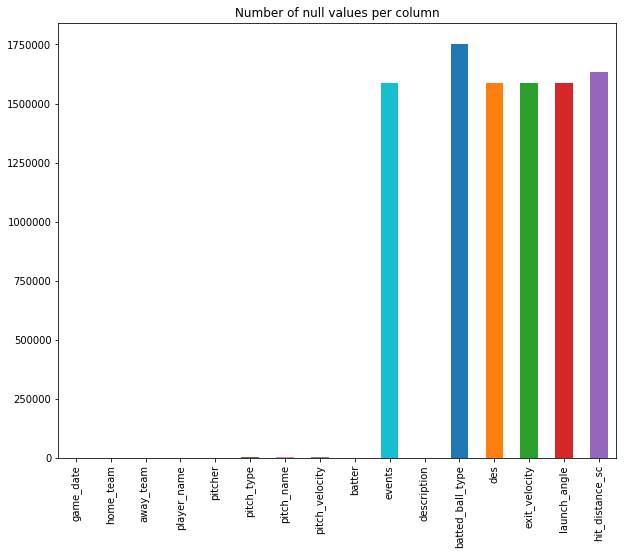

In [16]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

#### Approach for excluding records:

Each record represents an interaction between a pitcher and a batter (i.e., a pitch thrown by the pitcher to the batter).  The goal is to keep any interaction for which Statcast could provide valid measurements for the metrics `launch_speed`, `launch_angle`, and `hit_distance_sc`.

In order to do so, non-batted ball records will be excluded. <br>

- Drop all `events` = NaN which represent interactions where the batter did not make contact with the ball or the batter made contact with the ball but it was hit foul (e.g., ball, foul, called strike, swinging strike, blocked ball, foul tip, intentional ball, foul bunt, swinging strike blocked, missed bunt, pitchout)

- Drop all `batted_ball_type` = NaN which represents other remaining events where there was not a batted ball (e.g., strikeout, walk, hit by pitch, intentional walk, caught stealing, etc.)

#### Examine `events` column for missingness.

In [17]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

NaN                             1586052
field_out                        223381
strikeout                        116120
single                            82491
walk                              42138
double                            24898
home_run                          16629
force_out                         11500
grounded_into_double_play         11266
hit_by_pitch                       5019
field_error                        4816
sac_fly                            3549
sac_bunt                           3149
triple                             2607
intent_walk                        1884
double_play                        1348
fielders_choice_out                 919
caught_stealing_2b                  696
strikeout_double_play               435
fielders_choice                     301
pickoff_caught_stealing_2b          131
other_out                           120
catcher_interf                      113
pickoff_1b                           95
sac_fly_double_play                  66


In [18]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#cubs2016_new.events.isna() # alias of isnull()
null_events = all_MLB_teams2015_2017_new.events.isnull()
all_MLB_teams2015_2017_new[null_events]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.4,572761.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.8,572761.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.6,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,75.9,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139913,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.0,518792.0,NaN,ball,NaN,NaN,92.6,10.5026,186.0
2139911,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.7,407812.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139910,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,89.9,407812.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139908,2015-04-05,CHC,STL,Jon Lester,452657.0,SI,Sinker,91.1,425509.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139907,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.2,425509.0,NaN,foul,NaN,NaN,101.5,6.2577,186.0


#### What types of interactions occurred for missing `events`?

In [19]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new[null_events].description.value_counts(dropna=False)

ball                       676751
foul                       371731
called_strike              333190
swinging_strike            131229
blocked_ball                45367
foul_tip                    10704
foul_bunt                    6228
intent_ball                  4724
swinging_strike_blocked      4312
missed_bunt                  1299
pitchout                      510
swinging_pitchout               4
hit_into_play_score             1
foul_pitchout                   1
hit_into_play                   1
Name: description, dtype: int64

#### Drop missing values from `events` column.

In [20]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['events'], inplace=True)

#### Examine `batted_ball_type` column for missingness.

In [21]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False)

ground_ball    178646
NaN            166927
line_drive      99714
fly_ball        81752
popup           26829
Name: batted_ball_type, dtype: int64

In [22]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.batted_ball_type.isna() # alias of isnull()
null_batted_ball_type = all_MLB_teams2015_2017_new.batted_ball_type.isnull()
all_MLB_teams2015_2017_new[null_batted_ball_type]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139906,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,76.8,425509.0,strikeout,swinging_strike,NaN,Jhonny Peralta strikes out swinging.,NaN,NaN,NaN
2139901,2015-04-05,CHC,STL,Jon Lester,452657.0,FC,Cutter,89.9,571431.0,strikeout,swinging_strike,NaN,Matt Adams strikes out swinging.,NaN,NaN,NaN
2139890,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FC,Cutter,84.9,519203.0,strikeout,called_strike,NaN,Anthony Rizzo called out on strikes.,NaN,NaN,NaN
2139882,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.0,425877.0,strikeout,swinging_strike,NaN,Yadier Molina strikes out swinging.,NaN,NaN,NaN
2139875,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,89.6,543939.0,walk,ball,NaN,Kolten Wong walks.,NaN,NaN,NaN
2139866,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.1,425794.0,strikeout,called_strike,NaN,Adam Wainwright called out on strikes.,NaN,NaN,NaN
2139864,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,88.7,518792.0,caught_stealing_2b,ball,NaN,"With Jason Heyward batting, Matt Carpenter cau...",NaN,NaN,NaN
2139854,2015-04-05,CHC,STL,Adam Wainwright,425794.0,CU,Curveball,77.1,592609.0,strikeout,swinging_strike_blocked,NaN,Mike Olt strikes out swinging.,NaN,NaN,NaN
2139849,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FF,4-Seam Fastball,90.3,452657.0,strikeout,called_strike,NaN,Jon Lester called out on strikes.,NaN,NaN,NaN
2139837,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.7,425509.0,strikeout,called_strike,NaN,Jhonny Peralta called out on strikes.,NaN,NaN,NaN


#### What types of `events` occurred for missing `batted_ball_type`?

In [23]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new[null_batted_ball_type].events.value_counts(dropna=False)

strikeout                       116120
walk                             42138
hit_by_pitch                      5019
intent_walk                       1884
caught_stealing_2b                 696
strikeout_double_play              435
pickoff_caught_stealing_2b         131
other_out                          120
catcher_interf                     113
pickoff_1b                          95
caught_stealing_3b                  56
pickoff_2b                          55
caught_stealing_home                29
run                                 16
pickoff_caught_stealing_3b          10
batter_interference                  4
pickoff_caught_stealing_home         3
pickoff_3b                           3
Name: events, dtype: int64

#### Drop missing values from `batted_ball_type` column.

In [24]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['batted_ball_type'], inplace=True)

#### Confirm whether the values for `events` and `batted_ball_type` are valid (i.e., values could provide valid measurements for Statcast metrics).

In [25]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

field_out                    223381
single                        82491
double                        24898
home_run                      16629
force_out                     11500
grounded_into_double_play     11266
field_error                    4816
sac_fly                        3549
sac_bunt                       3149
triple                         2607
double_play                    1348
fielders_choice_out             919
fielders_choice                 301
sac_fly_double_play              66
triple_play                      18
sac_bunt_double_play              3
Name: events, dtype: int64

In [26]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False)

ground_ball    178646
line_drive      99714
fly_ball        81752
popup           26829
Name: batted_ball_type, dtype: int64

In [27]:
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False).sum()

386941

In [28]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.events, all_MLB_teams2015_2017_new.batted_ball_type, margins=True, margins_name='Total', dropna=False).style.background_gradient(cmap=orange)

batted_ball_type,fly_ball,ground_ball,line_drive,popup,Total
events,,,,,
double,3502,3342,17914,140,24898
double_play,222,109,930,87,1348
field_error,159,4349,199,109,4816
field_out,60230,103445,33726,25980,223381
fielders_choice,0,301,0,0,301
fielders_choice_out,0,914,2,3,919
force_out,47,11342,74,37,11500
grounded_into_double_play,0,11266,0,0,11266
home_run,11547,0,5082,0,16629


Note: The above frequencies confirm valid values.

In [29]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date               0
home_team               0
away_team               0
player_name             0
pitcher                 0
pitch_type            701
pitch_name            701
pitch_velocity        459
batter                  0
events                  0
description             0
batted_ball_type        0
des                     2
exit_velocity          66
launch_angle           66
hit_distance_sc     46472
dtype: int64

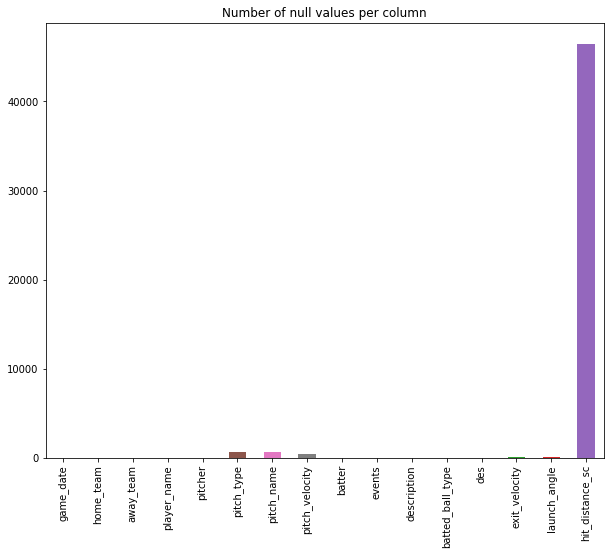

In [30]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

Note: There are still missing values for the following variables: `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle`. These variables will be used in the modeling and observations with missing values will be dropped.

#### Drop missing values from `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle` columns.

In [31]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['pitch_name', 'pitch_velocity', 'exit_velocity', 'launch_angle'], inplace=True)

### Summarize the DataFrame

In [32]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).describe()

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
count,386112.000000,386112.000000,386112.000000,340221.000000
mean,88.938052,87.228387,10.662181,170.446680
std,5.809726,14.532315,27.245971,136.700367
min,41.500000,5.200000,-88.890000,0.000000
25%,85.100000,80.000000,-8.987000,22.000000
50%,90.300000,89.300000,10.605000,169.000000
75%,93.300000,98.100000,28.520775,294.000000
max,105.400000,123.400000,89.850000,504.000000


In [33]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['home_team', 'away_team', 'player_name', 'des'], axis=1).describe(include='object')

,game_date,pitch_type,pitch_name,events,description,batted_ball_type
count,386112,386112,386112,386112,386112,386112
unique,537,16,16,16,4,4
top,2015-09-30,FF,4-Seam Fastball,field_out,hit_into_play,ground_ball
freq,974,131254,131254,222928,249245,178259


In [34]:
# Compute a frequency table of two factors
# Builtin-Styles - https://pandas.pydata.org/pandas-docs/stable/style.html
orange = sns.light_palette('orange', as_cmap=True)
pd.crosstab(all_MLB_teams2015_2017_new.pitch_name, all_MLB_teams2015_2017_new.pitch_type, margins=True, margins_name='Total').style.background_gradient(cmap=orange)

pitch_type,CH,CU,EP,FA,FC,FF,FO,FS,FT,KC,KN,PO,SC,SI,SL,UN,Total
pitch_name,,,,,,,,,,,,,,,,,
2-Seam Fastball,0,0,0,0,0,0,0,0,59444,0,0,0,0,0,0,0,59444
4-Seam Fastball,0,0,0,0,0,131254,0,0,0,0,0,0,0,0,0,0,131254
Changeup,43883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43883
Curveball,0,26046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26046
Cutter,0,0,0,0,21484,0,0,0,0,0,0,0,0,0,0,0,21484
Eephus,0,0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,114
Fastball,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3
Forkball,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,126
Knuckle Ball,0,0,0,0,0,0,0,0,0,0,2094,0,0,0,0,0,2094


#### Drop low frequency `pitch_name` observations

In [35]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['pitch_name_low_freq'] = np.where(all_MLB_teams2015_2017_new.pitch_name.isin(['Eephus', 'Fastball', 'Forkball', 'Pitch Out', 'Screwball', 'Unknown']), 1, 0)

In [36]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.pitch_name_low_freq.value_counts(dropna=False)

0    385848
1       264
Name: pitch_name_low_freq, dtype: int64

In [37]:
# Excluding low frequency values
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new[all_MLB_teams2015_2017_new.pitch_name_low_freq == 0]
all_MLB_teams2015_2017_new.drop('pitch_name_low_freq', axis=1, inplace=True)

In [38]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 385848, Cols: 16


In [39]:
# Calculate the correlation matrix using the default method (Pearson correlation)
baseball_correlations = all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).corr(method='pearson')
baseball_correlations

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
pitch_velocity,1.000000,0.078758,0.006906,0.016692
exit_velocity,0.078758,1.000000,0.186630,0.352101
launch_angle,0.006906,0.186630,1.000000,0.732524
hit_distance_sc,0.016692,0.352101,0.732524,1.000000


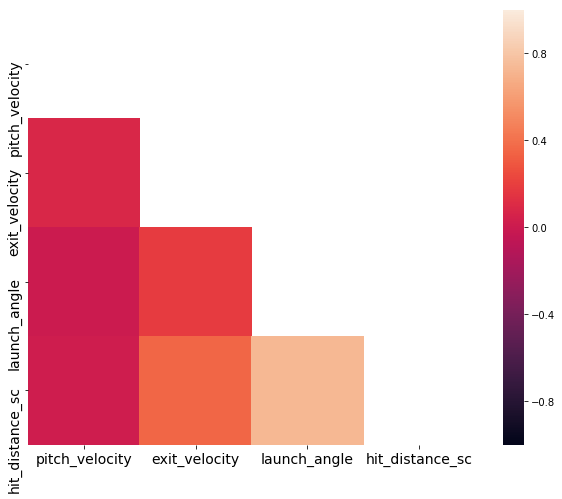

In [40]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(baseball_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
ax = sns.heatmap(baseball_correlations, vmin=-1, vmax=1, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14);

plt.show();

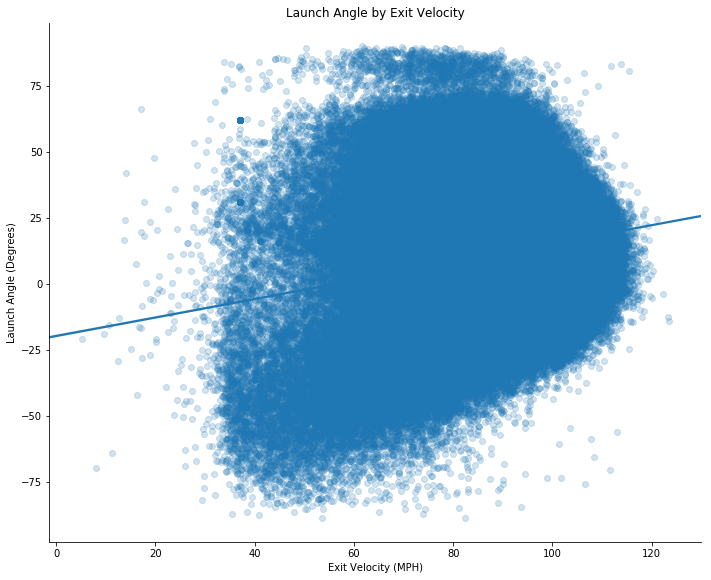

In [41]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       fit_reg=True estimates and plots a regression model relating the x and y variables
#       size: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * size" gives the width of each facet in inches
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='exit_velocity', y='launch_angle', data=all_MLB_teams2015_2017_new, fit_reg=True, size=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Launch Angle (Degrees)');
plt.title('Launch Angle by Exit Velocity');

In [42]:
# For each pitch name group, describe exit velocity:
all_MLB_teams2015_2017_new.groupby(by='pitch_name').exit_velocity.describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
2-Seam Fastball,59444.0,88.306505,14.647477,11.3,81.600,90.4,99.2,119.8
4-Seam Fastball,131254.0,88.488940,14.407276,5.2,80.800,90.7,99.0,123.4
Changeup,43883.0,85.212321,14.544717,17.4,77.900,86.2,96.1,121.1
Curveball,26046.0,85.792045,13.898408,16.4,79.100,87.5,96.1,120.3
Cutter,21484.0,85.716491,14.927310,17.2,78.500,87.6,96.9,117.3
Knuckle Ball,2094.0,86.755874,13.895962,32.7,80.000,88.7,97.0,115.5
Knuckle Curve,7419.0,86.756315,13.949537,22.6,80.000,88.7,97.2,116.9
Sinker,33090.0,88.197942,14.831403,12.4,81.600,90.3,99.2,119.0
Slider,54850.0,85.581256,14.282644,8.0,78.400,86.9,96.2,120.1


In [43]:
# For each pitch name group, describe launch angle:
all_MLB_teams2015_2017_new.groupby(by='pitch_name').launch_angle.describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
2-Seam Fastball,59444.0,5.805721,26.096482,-85.2330,-14.27200,5.11350,22.64125,89.316
4-Seam Fastball,131254.0,15.590254,27.207672,-87.4400,-2.72200,15.75285,33.31850,89.850
Changeup,43883.0,8.492420,27.431115,-84.9870,-12.00350,8.32800,26.38050,89.347
Curveball,26046.0,9.407879,26.598972,-86.6740,-9.48500,9.39830,27.10600,89.534
Cutter,21484.0,11.065092,27.403416,-88.8900,-8.46625,11.11700,29.26100,87.743
Knuckle Ball,2094.0,11.064694,28.925110,-81.7930,-9.84975,12.27600,30.07475,87.368
Knuckle Curve,7419.0,4.538567,25.384385,-82.1240,-14.86150,4.16700,20.98150,85.508
Sinker,33090.0,4.747631,25.787728,-87.4975,-15.75675,4.18900,21.67175,89.401
Slider,54850.0,11.229487,27.576563,-87.4580,-8.67350,11.12250,29.48750,89.277


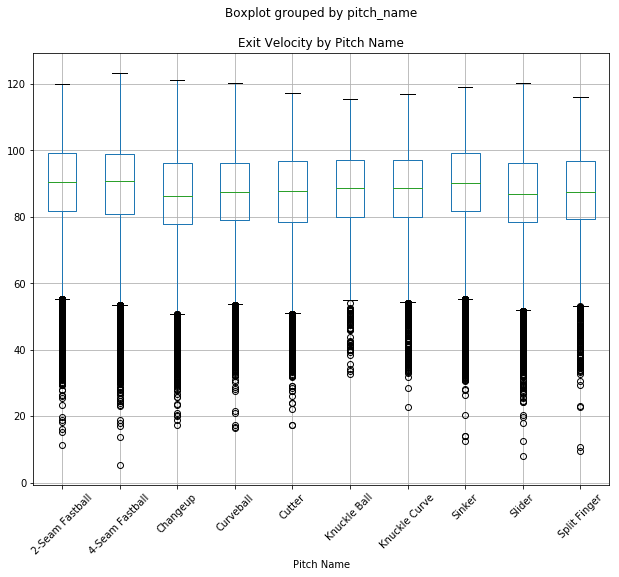

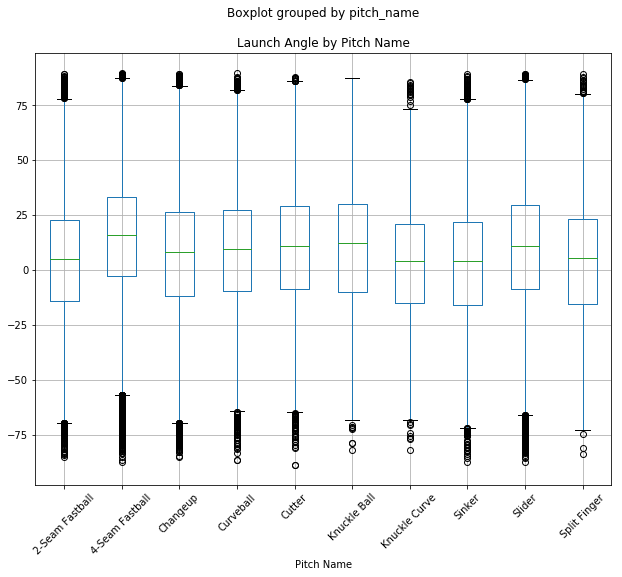

In [44]:
# Create box plots
# Note: column: used to limit data to a subset of columns
#       by: used to form box plots for separate groups
#       rot: rotation angle of labels (in degrees) with respect to the screen coordinate sytem
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.boxplot(column='exit_velocity', by='pitch_name', rot=45, figsize=(10, 8));
plt.xlabel('Pitch Name');
plt.title('Exit Velocity by Pitch Name');
plt.show()
all_MLB_teams2015_2017_new.boxplot(column='launch_angle', by='pitch_name', rot=45, figsize=(10, 8));
plt.xlabel('Pitch Name');
plt.title('Launch Angle by Pitch Name');

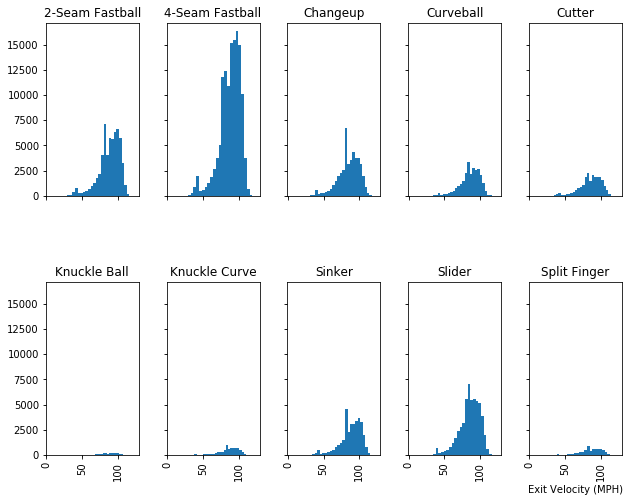

In [45]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
#       bins: number of histogram bins to be used
all_MLB_teams2015_2017_new.hist(column='exit_velocity', by='pitch_name', sharex=True, sharey=True, layout=(2, 5), figsize=(10, 8), bins=30);
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Frequency');

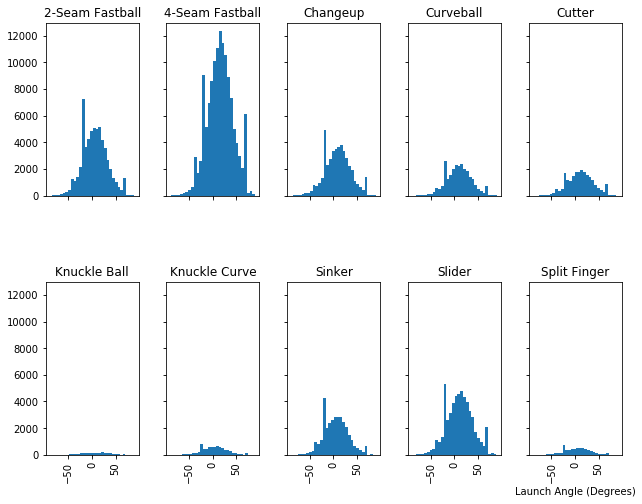

In [46]:
all_MLB_teams2015_2017_new.hist(column='launch_angle', by='pitch_name', sharex=True, sharey=True, layout=(2, 5), figsize=(10, 8), bins=30);
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Frequency');

### Data Modeling

### Using k-Means Algorithm for Clustering

Python Data Science Handbook: [In Depth: k-Means Clustering](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

k-means can be slow for large numbers of samples.<br>

Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind batch-based k-means algorithms, one form of which is implemented in `MiniBatchKMeans`. The interface for this is the same as for standard `KMeans`.

#### Build k-means clustering model

### Building Phase

#### Predicting Clusters

In [47]:
# Create a list of features
feature_cols = ['exit_velocity', 'launch_angle']

In [48]:
# Create X
X = all_MLB_teams2015_2017_new[feature_cols]

In [49]:
# Instantiate a StandardScaler object and compute the mean and std to be used for later scaling
# --> Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(X)

# Perform standardization by centering and scaling
X_scaled = scaler.transform(X)

In [50]:
X_scaled

array([[-0.22230744, -0.86847436],
       [ 0.80986632,  0.23259773],
       [ 0.19056207,  0.15919292],
       ...,
       [ 0.54150115,  0.6659797 ],
       [-0.31864366, -0.50523068],
       [-0.40809872,  1.46833094]])

In [51]:
# Create pandas dataframe from numpy array 
X_scaled_df = pd.DataFrame({'exit_velocity':X_scaled[:, 0], 'launch_angle':X_scaled[:, 1]})

Note: The number of clusters must be selected beforehand with k-means: it cannot learn the number of clusters from the data.

#### k-Means Clustering (k=3)

In [52]:
# Instantiate a k-means clustering model and compute k-means clustering
# Note: n_clusters: number of clusters to form as well as the number of centroids to generate
#       init: method for initialization; 'k-means++' (default) selects initial cluster centers for k-mean clustering
#             in a smart way to speed up convergence; 'random' chooses k observations (rows) at random from data for
#             the initial centroids
#       n_init: number of times (default=10) the k-means algorithm will be run with different centroid seeds;
#               the final results will be the best output of n_init consecutive runs in terms of inertia
#       random_state: the seed used by the random number generator
#       algorithm: K-means algorithm to use; the classical EM-style algorithm is "full"; the "elkan" variation is 
#                  more efficient by using the triangle inequality, but currently doesn't support sparse data; 
#                 "auto" (default) chooses "elkan" for dense data and "full" for sparse data
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=46, algorithm='auto')
kmeans.fit(X_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=46, tol=0.0001, verbose=0)

In [53]:
# Labels of each point
print(kmeans.labels_)
kmeans.labels_.shape

[1 2 2 ... 2 1 0]


(385848,)

In [54]:
# Predict the closest cluster each sample in X belongs to (i.e., "the index of the closest code in the code book")
clusters = kmeans.predict(X_scaled_df)
print(clusters)
clusters.shape

[1 2 2 ... 2 1 0]


(385848,)

In [55]:
# Coordinates of cluster centers (i.e., "the code book")
centroids = kmeans.cluster_centers_
print(centroids)
centroids.shape

[[-0.36389378  1.18178017]
 [-1.04934909 -1.07919723]
 [ 0.72568117 -0.08934393]]


(3, 2)

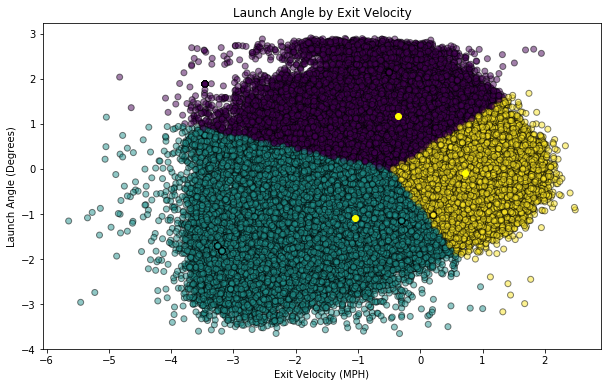

In [56]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(X_scaled_df.exit_velocity, X_scaled_df.launch_angle, c=clusters, cmap='viridis', alpha=0.5, edgecolors='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color='yellow')
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Launch Angle (Degrees)');
plt.title('Launch Angle by Exit Velocity');
plt.show()

#### k-Means Clustering (k=4)

In [57]:
# Instantiate a k-means clustering model and compute k-means clustering
# Note: n_clusters: number of clusters to form as well as the number of centroids to generate
#       init: method for initialization; 'k-means++' (default) selects initial cluster centers for k-mean clustering
#             in a smart way to speed up convergence; 'random' chooses k observations (rows) at random from data for
#             the initial centroids
#       n_init: number of times (default=10) the k-means algorithm will be run with different centroid seeds;
#               the final results will be the best output of n_init consecutive runs in terms of inertia
#       random_state: the seed used by the random number generator
#       algorithm: K-means algorithm to use; the classical EM-style algorithm is "full"; the "elkan" variation is 
#                  more efficient by using the triangle inequality, but currently doesn't support sparse data; 
#                 "auto" (default) chooses "elkan" for dense data and "full" for sparse data
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=46, algorithm='auto')
kmeans.fit(X_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=46, tol=0.0001, verbose=0)

In [58]:
# Labels of each point
print(kmeans.labels_)
kmeans.labels_.shape

[1 0 0 ... 0 1 2]


(385848,)

In [59]:
# Predict the closest cluster each sample in X belongs to (i.e., "the index of the closest code in the code book")
clusters = kmeans.predict(X_scaled_df)
print(clusters)
clusters.shape

[1 0 0 ... 0 1 2]


(385848,)

In [60]:
# Coordinates of cluster centers (i.e., "the code book")
centroids = kmeans.cluster_centers_
print(centroids)
centroids.shape

[[ 0.83345027  0.07895658]
 [-0.28040676 -0.84644098]
 [-0.41561465  1.2104338 ]
 [-2.28624588 -1.40861646]]


(4, 2)

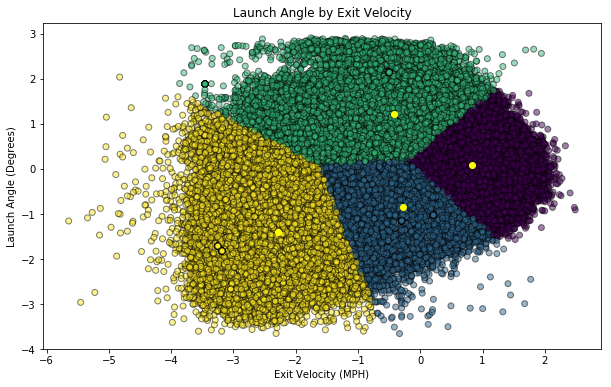

In [61]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(X_scaled_df.exit_velocity, X_scaled_df.launch_angle, c=clusters, cmap='viridis', alpha=0.5, edgecolors='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color='yellow')
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Launch Angle (Degrees)');
plt.title('Launch Angle by Exit Velocity');
plt.show()

#### k-Means Clustering (k=5)

In [62]:
# Instantiate a k-means clustering model and compute k-means clustering
# Note: n_clusters: number of clusters to form as well as the number of centroids to generate
#       init: method for initialization; 'k-means++' (default) selects initial cluster centers for k-mean clustering
#             in a smart way to speed up convergence; 'random' chooses k observations (rows) at random from data for
#             the initial centroids
#       n_init: number of times (default=10) the k-means algorithm will be run with different centroid seeds;
#               the final results will be the best output of n_init consecutive runs in terms of inertia
#       random_state: the seed used by the random number generator
#       algorithm: K-means algorithm to use; the classical EM-style algorithm is "full"; the "elkan" variation is 
#                  more efficient by using the triangle inequality, but currently doesn't support sparse data; 
#                 "auto" (default) chooses "elkan" for dense data and "full" for sparse data
k=5
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=46, algorithm='auto')
kmeans.fit(X_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=46, tol=0.0001, verbose=0)

In [63]:
# Labels of each point
print(kmeans.labels_)
kmeans.labels_.shape

[0 2 2 ... 2 0 3]


(385848,)

In [64]:
# Predict the closest cluster each sample in X belongs to (i.e., "the index of the closest code in the code book")
clusters = kmeans.predict(X_scaled_df)
print(clusters)
clusters.shape

[0 2 2 ... 2 0 3]


(385848,)

In [65]:
# Coordinates of cluster centers (i.e., "the code book")
centroids = kmeans.cluster_centers_
print(centroids)
centroids.shape

[[-0.15856216 -0.99278232]
 [-1.02127901  0.31855749]
 [ 0.83434296  0.06430911]
 [-0.11932954  1.42152417]
 [-2.31542123 -1.64880628]]


(5, 2)

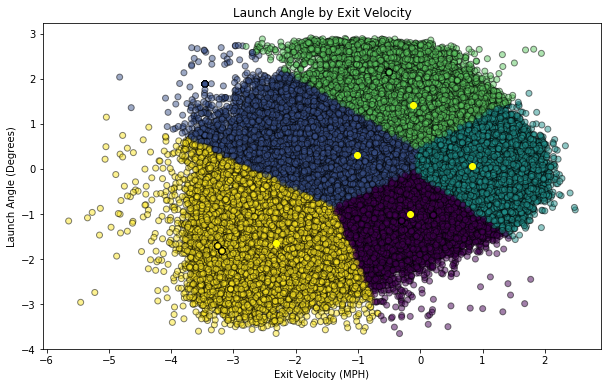

In [66]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(X_scaled_df.exit_velocity, X_scaled_df.launch_angle, c=clusters, cmap='viridis', alpha=0.5, edgecolors='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color='yellow')
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Launch Angle (Degrees)');
plt.title('Launch Angle by Exit Velocity');
plt.show()

#### Elbow Method For Optimal k

Introduction to K-means Clustering: [Choosing k](https://www.datascience.com/blog/k-means-clustering)

##### Method 1
Determine optimal k: [Use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster center](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [67]:
# Calculating sum of squared distances of samples to their closest cluster center
sum_of_squared_distances = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=46, algorithm='auto')
    kmeans = kmeans.fit(X_scaled_df)
    sum_of_squared_distances.append(kmeans.inertia_)

In [68]:
sum_of_squared_distances

[771696.0000000005,
 471163.2976129615,
 299257.274693282,
 219375.04221941667,
 180312.1378032274,
 146235.30944430802,
 127347.10202247446,
 110975.99417197348,
 97525.74579354611,
 87371.81165263138]

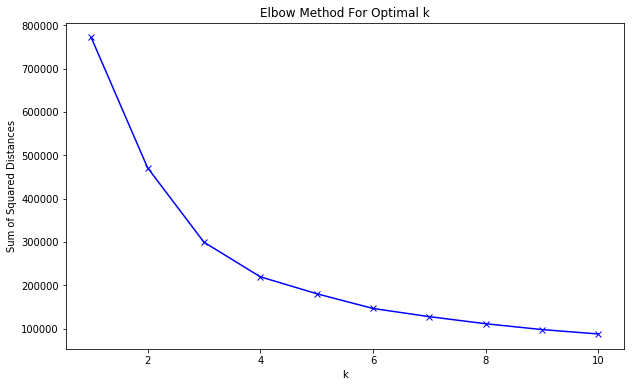

In [69]:
fig = plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

##### Method 2
Determine optimal k: [Use average sum of squared distances of samples to their closest cluster center (distortion)](https://pythonprogramminglanguage.com/kmeans-elbow-method/)

In [70]:
from scipy.spatial.distance import cdist

In [71]:
# Calculating average sum of squared distances of samples to their closest cluster center (distortion)
ave_distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=46, algorithm='auto')
    kmeans = kmeans.fit(X_scaled_df)
    ave_distortions.append(sum(np.square(np.min(cdist(X_scaled_df, kmeans.cluster_centers_, metric='euclidean'), axis=1))) / X_scaled_df.shape[0])

In [72]:
ave_distortions

[1.999999999998735,
 1.2211111567585822,
 0.7755833247632756,
 0.5685530110807291,
 0.46731391066737965,
 0.37899719434668144,
 0.3300447378824945,
 0.2876158336236904,
 0.25275690373801935,
 0.2264410121411589]

Note: ave_distortions = kmeans.inertia_ / X_scaled_df.shape[0]

In [73]:
sum_of_squared_distances[9] / X_scaled_df.shape[0]

0.2264410121411317

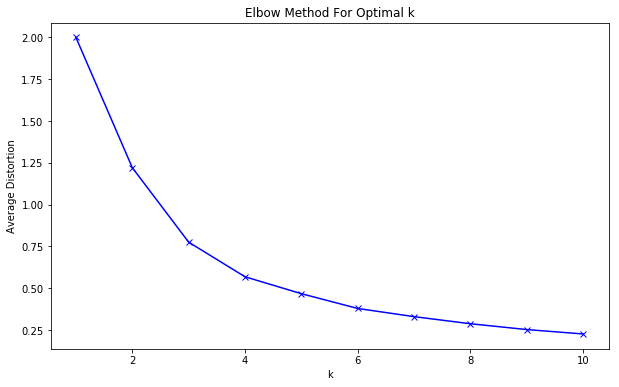

In [74]:
fig = plt.figure(figsize=(10, 6))
plt.plot(K, ave_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

### Alternative clustering algorithm to find the more complicated nonlinear boundaries between clusters

#### Spectral Clustering (n=2)

Note: Takes a very long time.

In [75]:
# Instantiate a spectral clustering model and create an affinity matrix for X using the selected affinity,
#    then apply spectral clustering to this affinity matrix
# Note: n_clusters: dimension of the projection subspace
#       random_state: the seed used by the random number generator
#       n_init: number of times (default=10) the k-means algorithm will be run with different centroid seeds;
#               the final results will be the best output of n_init consecutive runs in terms of inertia
#       affinity: 'nearest_neighbors', 'precomputed', 'rbf' (default) or one of the kernels supported 
#                  by `sklearn.metrics.pairwise_kernels`
#       assign_labels: strategy to use to assign labels in the embedding space; there are two ways to assign labels
#                      after the laplacian embedding; 'k-means' can be applied and is a popular choice, but it can
#                      also be sensitive to initialization; discretization is another approach which is less sensitive
#                      to random initialization
#n=2
#spectral = SpectralClustering(n_clusters=n, random_state=46, n_init=10, affinity='nearest_neighbors', assign_labels='kmeans')
#spectral.fit(X)

In [76]:
# Labels of each point
#print(spectral.labels_)
#spectral.labels_.shape

In [77]:
# Predict the closest cluster each sample in X belongs to (i.e., "the index of the closest code in the code book")
#clusters = spectral.predict(X)
#print(clusters)
#clusters.shape

In [78]:
# Affinity matrix used for clustering; available only if after calling 'fit'
#affinity_matrix = spectral.affinity_matrix_
#print(affinity_matrix)
#affinity_matrix.shape

In [79]:
#fig = plt.figure(figsize=(10, 6))

#plt.scatter(X.exit_velocity, X.launch_angle, c=clusters, cmap='viridis', alpha=0.5, edgecolors='k')
#for idx, affinity_matrix1 in enumerate(affinity_matrix):
#    plt.scatter(*affinity_matrix1, color='yellow')
#plt.xlabel('Exit Velocity (MPH)');
#plt.ylabel('Launch Angle (Degrees)');
#plt.title('Launch Angle by Exit Velocity');
#plt.show()